# Using Neural Network to identify diabete patients

This notebook is an exercise of using artificial neural network to identify cases where the patient has diabetes. The data is obtained from open sourced directory. 

I previously downloaded from a blog which teachs artificial intelligence but I cannot find the original page. I find a similar source from Kaggle.

https://www.kaggle.com/mathchi/diabetes-data-set

Written by Shing Chi Leung at 29 Jan 2021

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

Connect to the google network to read the file

In [ ]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


# 1. Read and Data-Processing for Train/Test 

Build methods for extracting the data, its normalization and its splitting for training

In [ ]:
file_path = "gdrive/MyDrive/Colab Notebooks/diabetes.csv"

def read_file(file_path):

    raw_data = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            new_line = [float(num) for num in line.strip().split(",")]
            raw_data.append(new_line)

    return np.array(raw_data)

def normalize_data(raw_data):
    normalizer = MinMaxScaler()
    normalizer.fit(raw_data)
    normalized_data = normalizer.transform(raw_data)

    return normalized_data, normalizer

def split_data(data):

    x_train, x_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1:], test_size = 0.2)
    return x_train, x_test, y_train, y_test

raw_data = read_file(file_path)
print("First 3 rows of raw data: {}\n".format(raw_data[:3]))

normalized_data, normalizer = normalize_data(raw_data)
print("First 3 rows of processed data:\n {}\n".format(normalized_data[:3,-1:]))

x_train, x_test, y_train, y_test = split_data(normalized_data)
print(x_train.shape)

First 3 rows of raw data: [[  6.    148.     72.     35.      0.     33.6     0.627  50.      1.   ]
 [  1.     85.     66.     29.      0.     26.6     0.351  31.      0.   ]
 [  8.    183.     64.      0.      0.     23.3     0.672  32.      1.   ]]

First 3 rows of processed data:
 [[1.]
 [0.]
 [1.]]

(614, 8)


# 1b. Raw Data Visualization

Before using the neural network to directly crunch for the solution, it is educational to look at the distribution of the data to see if there are already some direct relations among variables. 

['green', 'green', 'red', 'green', 'green']


Text(0, 0.5, 'age')

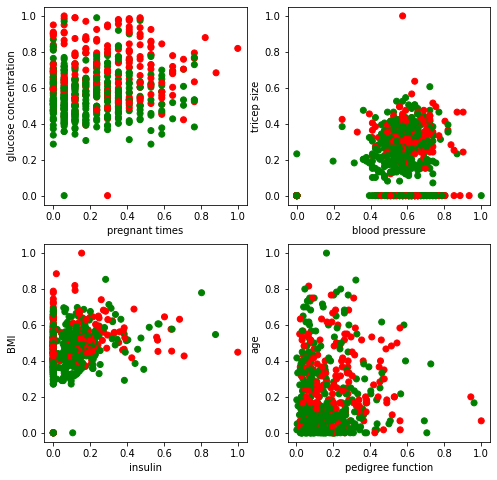

In [ ]:
figure1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(8,8), ncols=2, nrows=2)

colour_list = ['green', 'red']
colour_map = [colour_list[int(y)] for y in y_train]

print(colour_map[:5])

ax1.scatter(x_train[:,0],x_train[:,1], c=colour_map)
ax1.set_xlabel("pregnant times")
ax1.set_ylabel("glucose concentration")

ax2.scatter(x_train[:,2],x_train[:,3], c=colour_map)
ax2.set_xlabel("blood pressure")
ax2.set_ylabel("tricep size")

ax3.scatter(x_train[:,4],x_train[:,5], c=colour_map)
ax3.set_xlabel("insulin")
ax3.set_ylabel("BMI")

ax4.scatter(x_train[:,6],x_train[:,7], c=colour_map)
ax4.set_xlabel("pedigree function")
ax4.set_ylabel("age")

A few observations can already be drawn based on the distribution of the red (positive) and green (negative) case. A high glucose level will trigger diabetes more likely. Tricep size and blood glucose have a mixed effect to diabetes. Higher BMI is more likely to trigger diabetes. Lastly, age and pedigree function have mixed effects on the occurance of insulin. From these plots, these two parameters are more likely to affect diabeters: 

1. High glucose concentration
2. High BMI

This suggests that the cause of diabete have multiple causes by some of the parameters above and we need to disentangle the important parameters. 

# 2. Neural Network Constuction and Training

Then, I will build the model using simple dense fully-connected layers. For this model, I try to use more layers so that the non-linearity of data, as we see from the above figures, can be modeled. I used three layers of fully connected Dense network to achieve this. 

In [ ]:
def build_model(input_shape):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(8, activation="relu", input_shape=input_shape))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    return model

model = build_model(x_train[0].shape)
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


I also write separate methods for compiling and training the models so that changes in any part of the architecture can be updated individually without rerunning the whole program. 

In [ ]:
def compile_model(model):

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

compile_model(model)

In [ ]:
def train_model(model, x_train, y_train):

    history = model.fit(x_train, y_train, batch_size=32, epochs=70, verbose=0, validation_split=0.2)
    return history

#print(x_train.shape)
#print(y_train.shape)

history = train_model(model, x_train, y_train)
history.history["accuracy"][-1]

0.7841140627861023

# 3. Visualization of the Training Process

Finally, I plot the training history and check how well the neural network does in predicting the diabete rate. 

Text(0.5, 1.0, 'Training History')

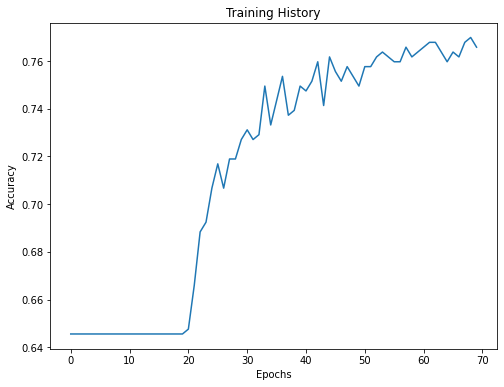

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1)
ax.plot(history.history["accuracy"])

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Training History")

The training is not bad that it reaches about 80% within tens of epochs. It seems it has reached its asymptotic value as well. 

In [ ]:
output = model.evaluate(x_test, y_test)
print("Finaly accuracy for the test data is {}".format(output[1]))

5/5 [==============================] - 0s 2ms/step - loss: 0.4432 - accuracy: 0.7857
Finaly accuracy for the test data is 0.7857142686843872


The test-set, which is not seen by the neural network, also achieves a similar accuracy as the training set. This shows that the current neural network is well trained (not over-fit or under-fit). However, since there are only a few hundred entries of raw data, with the inherent diversty of data, we can conclude that the current neural network has classfied the dataset well. 